In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

from scipy.special import softmax

In [2]:
df_matches = pd.read_csv("matches.csv")

In [8]:
df_matches["leagueSeason"].value_counts()

leagueSeason
2010    306
2011    306
2012    306
2013    306
2014    306
2015    306
2016    306
2017    306
2018    306
2019    306
2020    306
2021    306
2022    306
2023    306
Name: count, dtype: int64

In [36]:
df_matches.sort_values("leagueSeason")
splits = []
split_test_seasons = []
years = df_matches["leagueSeason"].unique()
for i in range(1, len(years)):
    min_year = years[0]
    test_year = years[i]
    train_rows = df_matches[(df_matches["leagueSeason"] >= min_year) & (df_matches["leagueSeason"] < test_year)]
    test_rows = df_matches[df_matches["leagueSeason"] == test_year]
    splits.append((train_rows.index, test_rows.index))
    split_test_seasons.append(years[i])

splits[0]


(Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
        ...
        296, 297, 298, 299, 300, 301, 302, 303, 304, 305],
       dtype='int64', length=306),
 Index([306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
        ...
        602, 603, 604, 605, 606, 607, 608, 609, 610, 611],
       dtype='int64', length=306))

In [13]:
def to_labels(df):
    return df[["team1Goals", "team2Goals"]].values

to_labels(df_matches)

array([[1, 0],
       [4, 1],
       [1, 1],
       ...,
       [4, 1],
       [4, 0],
       [4, 1]])

In [46]:
class StaticEstimator(BaseEstimator):
    def __init__(self, result) -> None:
        super().__init__()
        self.result = result

    def fit(self, X, y):
        pass

    def predict(self, X):
        results = np.zeros((len(X), 2))
        results[:] = self.result
        return results



In [35]:
def compute_kicktipp_score(predictions, y):
    predictions_draw = predictions[:, 0] == predictions[:, 1]
    predictions_win1 = predictions[:, 0] > predictions[:, 1]
    predictions_win2 = predictions[:, 0] < predictions[:, 1]
    predictions_diff = predictions[:, 0] - predictions[:, 1]
    y_draw = y[:, 0] == y[:, 1]
    y_win1 = y[:, 0] > y[:, 1]
    y_win2 = y[:, 0] < y[:, 1]
    y_diff = y[:, 0] - y[:, 1]

    correct_result = (predictions[:, 0] == y[:, 0]) & (predictions[:, 1] == y[:, 1])
    correct_result_win = (correct_result & y_win1) | (correct_result & y_win2)
    correct_result_draw = correct_result & (~correct_result_win)
    correct_tendency_win = (predictions_win1 & y_win1) | (predictions_win2 & y_win2)
    correct_tendency_draw = (predictions_draw & y_draw)
    correct_diff_win = (predictions_diff == y_diff) & correct_tendency_win

    score = 0
    score += np.count_nonzero(correct_result) * 4
    score += np.count_nonzero(correct_diff_win & (~correct_result)) * 3
    score += np.count_nonzero(correct_tendency_draw & (~correct_result_draw)) * 2
    score += np.count_nonzero(correct_tendency_win & (~correct_result_win) & ~(correct_diff_win)) * 2
    return score

def kicktipp_scoring(estimator, X, y):
    predictions = estimator.predict(X)
    return compute_kicktipp_score(predictions, y)

assert compute_kicktipp_score(np.array([[0, 0], [1, 1]]), np.array([[0, 0], [1, 1]])) == 8
assert compute_kicktipp_score(np.array([[0, 0], [2, 1]]), np.array([[0, 0], [1, 1]])) == 4
assert compute_kicktipp_score(np.array([[0, 0], [1, 1]]), np.array([[0, 0], [1, 2]])) == 4
assert compute_kicktipp_score(np.array([[0, 0], [2, 1]]), np.array([[0, 0], [1, 0]])) == 7
assert compute_kicktipp_score(np.array([[1, 0], [2, 1]]), np.array([[0, 0], [1, 0]])) == 3
assert compute_kicktipp_score(np.array([[1, 3], [1, 1], [3, 0], [1, 1], [0, 2], [1, 1], [3, 1], [1, 3], [1, 1]]), np.array([[2, 3], [3, 2], [1, 0], [2, 2], [3, 1], [1, 1], [2, 0], [2, 3], [0, 2]])) == 15


In [64]:
static_results = [[0, 0], [1, 1], [1, 0], [0, 1]]
all_scores = []
for result in static_results:
    scores = cross_val_score(StaticEstimator(result), df_matches, to_labels(df_matches), cv=splits, scoring=kicktipp_scoring)
    all_scores.append(scores)

all_scores = np.array(all_scores)
print(all_scores.shape)

(4, 13)


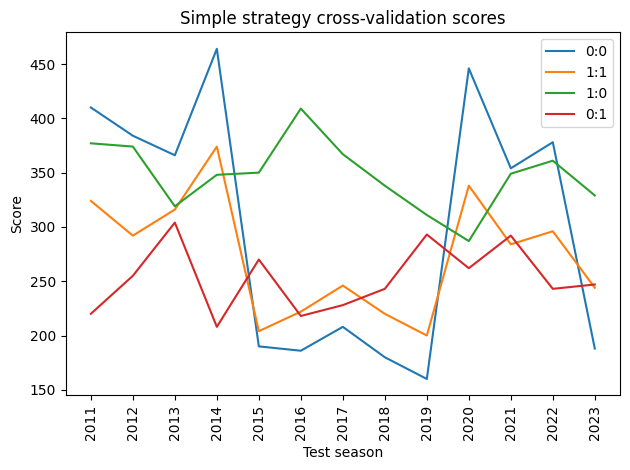

In [90]:
fig, ax = plt.subplots()
ax.plot(all_scores.T, label=[f"{res[0]}:{res[1]}" for res in static_results])
ax.set_xticks(range(len(split_test_seasons)), split_test_seasons, rotation=90, ha='center')
ax.set_xlabel("Test season")
ax.set_ylabel("Score")
ax.legend()
ax.set_title("Simple strategy cross-validation scores")
fig.tight_layout()
!